In [1]:
# import libraries
from sodapy import Socrata

import pandas as pd
import numpy as np
from collections import Counter
import operator as op

import seaborn as sns
import matplotlib.pyplot as plt

import pylab
import scipy.stats as stats
from random import shuffle

In [2]:
# go through registration and get token
socrata_token = 'U8U45oyFNQgOwzwhcsOYanoYs'

# access datasets from NYC OPEN DATA via API; I only use datasets with respect to yellow and green taxi (FHV dataset does not include payment data and is generally of different nature)
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = {'2019YT' : '2upf-qytp', '2019GT' : 'q5mz-t52e', '2020YT' : 'kxp8-n2sj', '2020GT' : 'pkmi-4kfn'}
client = Socrata(socrata_domain, socrata_token)
client.timeout = 100000

# Part 1. Payment amount distribution

In [ ]:
# initial datasets include all-year data: select only December data in 2019 and only January data in 2020
# in general monthly datasets are large and based on the task questions I guess downloading all columns is redundant: select only total_amount column
# for some reason 2019 and 2020 datasets also include a few rows corresponding to different random years (some bag), so I only select rows with the year in question

# the following code downloads yellow-taxi dataset total_amount column for December 2019 and saves data into array (other 3 datasets are handled in the same fashion)
#results = client.get(socrata_dataset_identifier['2019YT'], select = 'total_amount', where = 'date_extract_m(tpep_pickup_datetime) = 12 and date_extract_y(tpep_pickup_datetime) = 2019', limit = 7000000)
#yt_2019_ta = np.array([*map(float, [*map(lambda x: x['total_amount'], results)])])

# code for green-taxi 2019 data
#results = client.get(socrata_dataset_identifier['2019GT'], select = 'total_amount', where = 'date_extract_m(lpep_pickup_datetime) = 12 and date_extract_y(lpep_pickup_datetime) = 2019', limit = 7000000)
#gt_2019_ta = np.array([*map(float, [*map(lambda x: x['total_amount'], results)])])

# code for yellow-taxi 2020 data
#results = client.get(socrata_dataset_identifier['2020YT'], select = 'total_amount', where = 'date_extract_m(tpep_pickup_datetime) = 1 and date_extract_y(tpep_pickup_datetime) = 2020', limit = 7000000)
#yt_2020_ta = np.array([*map(float, [*map(lambda x: x['total_amount'], results)])])

# code for green-taxi 2020 data
#results = client.get(socrata_dataset_identifier['2020GT'], select = 'total_amount', where = 'date_extract_m(lpep_pickup_datetime) = 1 and date_extract_y(lpep_pickup_datetime) = 2020', limit = 7000000)
#gt_2020_ta = np.array([*map(float, [*map(lambda x: x['total_amount'], results)])])

Strictly speaking, one can aggregate data from different months and from different taxi types only if she is sure that they come from one distribution. I visually studied the distributions for each group and found that they are indeed similar. And that is not striking since there is no reason why payment patterns should vary form one month to another (provided that these months are consequent) and in thier nature service of green and yellow taxi is the same. 

In [48]:
# aggregate all data into one array
agg_ta = np.array([])
lst =[yt_2019_ta, gt_2019_ta, yt_2020_ta, gt_2020_ta]
for i, name in enumerate(lst):
    agg_ta = np.append(agg_ta, name)

In [72]:
# decribe the array
stats.describe(agg_ta)

DescribeResult(nobs=14199588, minmax=(-1472.8, 398471.2), mean=19.148083084523282, variance=11409.669245800078, skewness=3655.496568545957, kurtosis=13635856.204622027)

Extreme values are outstanding: I see no sense in negative total amount, and nearly 400.000 dollars for a ride seems to be unrealistic (Nowadays space flight is twice cheaper :)). I guess the source of these outliers is in some error.    

In [79]:
# get use of quantiles
print('99% of data is between {} and {}'.format(np.quantile(agg_ta, 0.005), np.quantile(agg_ta, 0.995)))


99% of data is between 3.8 and 81.92


Now picture makes sense: most of payments are below 100 dollars

<Figure size 432x288 with 0 Axes>

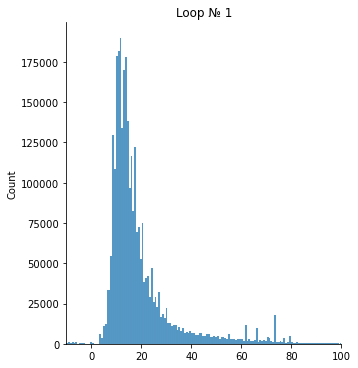

<Figure size 432x288 with 0 Axes>

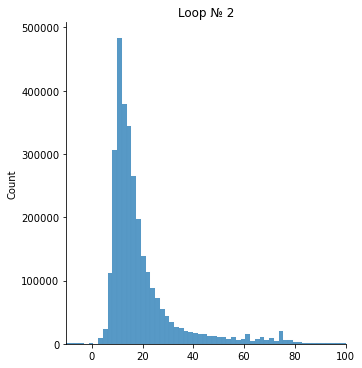

<Figure size 432x288 with 0 Axes>

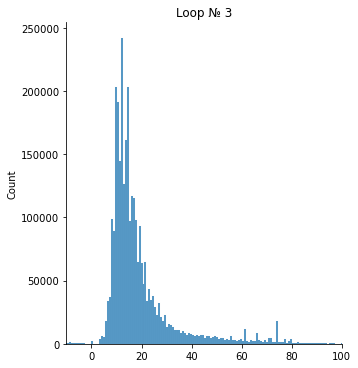

In [100]:
# plot histograms over random subsets of the array   
for i in range(3):
    plt.figure()
    shuffle(agg_ta)
    ax = sns.displot(agg_ta[:3000000], bins = 4000)
    plt.xlim(-10, 100)
    plt.title('Loop № {}'.format(i+1))

(-10.0, 100.0)

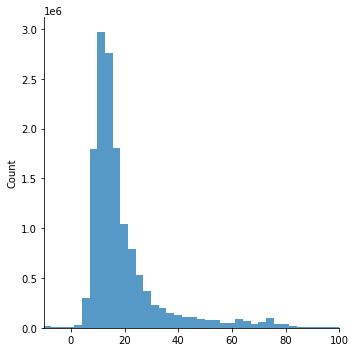

In [96]:
# plot histogram over the whole array
# takes time to run the code
ax = sns.displot(agg_ta, bins = 140000)
plt.xlim(-10, 100)

Distributions of random subsets follow the distribution of the whole dataset, which includes over 14 million points.

Visual analysis favors the rejection of the hypothesis of normal distribution: at least values are not symmetrically distibuted around mean 19.15.

In fact more than 70% of the payments are mostly centered around 10-19 dollars, which is below the mean. This implies that mostly people hire taxi for a medium time-distance ride, because the largest part of the total payment is the time-and-distance fare calculated by the meter.
Approximately 30% of the payments are above the mean, implying right heavy tail: indeed we can see some spikes around 60 and 70 dollars.
    
All in all, the distribution of payments is not normal, since mostly people hire taxi for a medium time-distance ride, while hardly anyone hires taxi for a very short time-distance ride (it is easier to go on foot or take bicycle). But people also use taxi for high time-distance rides, though not as often as for medium time-distance rides.

Now perform some statistcal tests. Filter agg_ta for outliers: consider point to be an outlier if it is negative or above 1000.


In [130]:
# perform Jarque–Bera test for Normality (skewness and kurosis comparison)
stat, p = stats.jarque_bera(agg_ta[np.where((agg_ta > 0)&(agg_ta<1000))])
print('stat: {}, p: {}'.format(stat, p))
if p > 0.01:
    print('Do not reject the hypothesis')
else:
    print('Reject the hypothesis')

stat: 1343555459.8742979, p: 0.0
Reject the hypothesis


In [131]:
# perform D’Agostino’s K-squared test (skewness and kurosis comparison)
stat, p = stats.normaltest(agg_ta[np.where((agg_ta > 0)&(agg_ta<1000))])
print('stat: {}, p: {}'.format(stat, p))
if p > 0.01:
    print('Do not reject the hypothesis')
else:
    print('Reject the hypothesis')

stat: 12970486.061229452, p: 0.0
Reject the hypothesis


In [132]:
# perform Kolmogorov-Smirnov test for Normality test (difference between the empirical distribution function and the cumulative distribution function of the reference distribution)
stat, p = stats.kstest(agg_ta[np.where((agg_ta > 0)&(agg_ta<1000))], 'norm')
print('stat: {}, p: {}'.format(stat, p))
if p > 0.01:
    print('Do not reject the hypothesis')
else:
    print('Reject the hypothesis')

stat: 0.9992569546261961, p: 0.0
Reject the hypothesis


# Part 2. Trip direction and time

For this task I divide data into two groups based on the taxi type since yellow and green caps operation area differs a little bit.

# Green Taxi Data

In [3]:
# download data for green taxi (as I understand soda does not provide for grouping by multiple columns, so I will perform grouping later in pandas)
results_2019 = client.get(socrata_dataset_identifier['2019GT'], select = 'date_extract_hh(lpep_pickup_datetime), PULocationID, DOLocationID', where = 'date_extract_m(lpep_pickup_datetime) = 12 and date_extract_y(lpep_pickup_datetime) = 2019', limit = 7000000)
results_2020 = client.get(socrata_dataset_identifier['2020GT'], select = 'date_extract_hh(lpep_pickup_datetime), PULocationID, DOLocationID', where = 'date_extract_m(lpep_pickup_datetime) = 1 and date_extract_y(lpep_pickup_datetime) = 2020', limit = 7000000)
results = results_2019 + results_2020
gt = pd.DataFrame.from_dict(results)

In [27]:
# add new column representing direction of each trip and count the number of each trip occurence
gt['start-end'] = gt.apply(lambda row: '{}:{}'.format(row['PULocationID'], row['DOLocationID'] ), axis=1)


In [28]:
# print 20 most common directions
lst_top = [*map(op.itemgetter(0), list(Counter(gt['start-end']).most_common(20)))]
print(lst_top)

['75:74', '7:7', '74:75', '95:95', '41:42', '82:129', '74:74', '41:41', '74:41', '42:42', '41:74', '82:82', '75:75', '129:129', '223:223', '74:42', '74:236', '42:41', '7:223', '166:166']


In general most popular rides are taken within one taxi zone or between two neigborhood taxi zones. Actually consequent taxi zone numbers do not necessarily indicate that these two zones are neighbors, so it is better to check out the map.
This is expected because the previous subtask revealed that majority of the rides are medium in time-distant dimension.

The popularity of these directions might be due the fact that these taxi zones are densely populated and people commute to workplace in the morning and return back home in the evening. Concrete illustrations will be provided after analazing yellow taxi traffic.

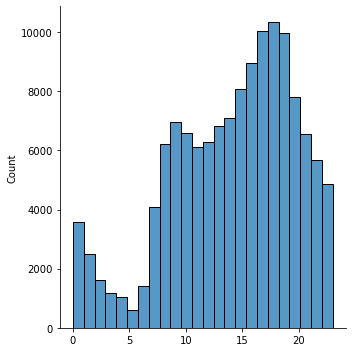

In [30]:
# plot histogram by hour only among top 20 common directions
ax = sns.displot([*map(int, gt[gt['start-end'].isin(lst_top)]['date_extract_hh_lpep_pickup_datetime'])], bins = 24)

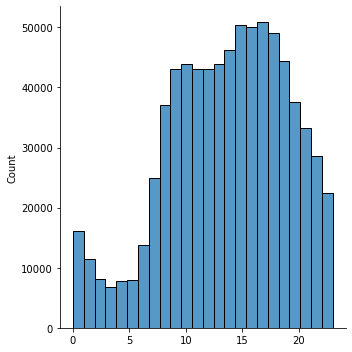

In [31]:
# plot histogram by hour only among other (excluding top 20) not vey common directions
ax = sns.displot([*map(int, gt[~gt['start-end'].isin(lst_top)]['date_extract_hh_lpep_pickup_datetime'])], bins = 24)

Comparing distributions by hour of most common trips and not very common trips does not reveal any specific patterns of each group. Threre are some spikes around 9-10 am and 18-19 pm in each group confirming the proposition of commuting. In both groups spikes in the evening are higher which might be explained by the fact that people tend to attend entartainment entities after work or during weekend in the evining.

Since distributions of each group do not differ much, I favor the proposition that the popularity of certain directions is connected with the population number of corresponding zones, i.e. I doubt that there is some structural reason to the popularity of certain directions and suggest that popularity is just the matter of the population number of certain zones.

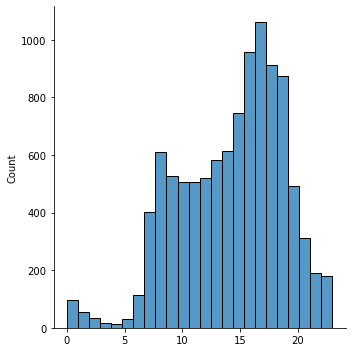

In [90]:
# plot distribution by hour for "Manhattan","East Harlem South","Boro Zone" - "Manhattan","East Harlem North","Boro Zone"
ax = sns.displot([*map(int, gt[gt['start-end'] == '75:74']['date_extract_hh_lpep_pickup_datetime'])], bins = 24)

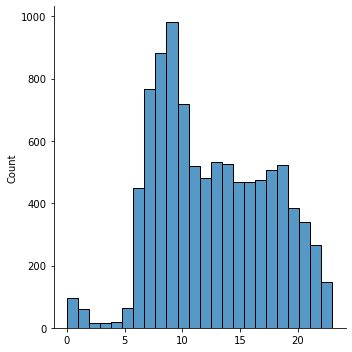

In [91]:
# plot distribution by hour for "Manhattan","East Harlem North","Boro Zone" - "Manhattan","East Harlem South","Boro Zone"
ax = sns.displot([*map(int, gt[gt['start-end'] == '74:75']['date_extract_hh_lpep_pickup_datetime'])], bins = 24)

Plots above show that people presumambly reside in the south part of East Harlem and commute to work to the north part. By the the way Manhattan is the most densely populated part of NYC and Harlem is the third largest district in Manhattan by population.

# Yellow Taxi Data

In [3]:
# download data for yellow taxi (as I understand soda does not provide for grouping by multiple columns, so I will perform grouping later in pandas)
results_2019 = client.get(socrata_dataset_identifier['2019YT'], select = 'date_extract_hh(tpep_pickup_datetime), PULocationID, DOLocationID', where = 'date_extract_m(tpep_pickup_datetime) = 12 and date_extract_y(tpep_pickup_datetime) = 2019', limit = 7000000)
results_2020 = client.get(socrata_dataset_identifier['2020YT'], select = 'date_extract_hh(tpep_pickup_datetime), PULocationID, DOLocationID', where = 'date_extract_m(tpep_pickup_datetime) = 1 and date_extract_y(tpep_pickup_datetime) = 2020', limit = 7000000)
results = results_2019 + results_2020
yt = pd.DataFrame.from_dict(results)

In [3]:
# add new column representing direction of each trip and count the number of each trip occurence
yt['start-end'] = yt.apply(lambda row: '{}:{}'.format(row['PULocationID'], row['DOLocationID'] ), axis=1)

In [4]:
# print 20 most common directions
lst_top_yt = [*map(op.itemgetter(0), list(Counter(yt['start-end']).most_common(20)))]
print(lst_top_yt)

['237:236', '236:236', '236:237', '237:237', '264:264', '239:238', '239:142', '142:239', '237:162', '186:230', '237:161', '161:237', '238:239', '141:236', '230:186', '186:161', '237:141', '263:236', '239:239', '48:48']


The interesting observation about Yellow Taxi Data is that all 20 most common directions are within Manhattan. Manhattan is only the third largest borough of NYC by population after Brooklyn and Queens, though the densest. I guess the popularity of these directions is connected with the fact that Manhattan is home to many tourist attractions and shoppping centers.

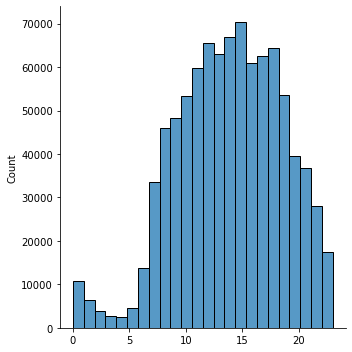

In [5]:
# plot histogram by hour only among top 20 common directions
ax = sns.displot([*map(int, yt[yt['start-end'].isin(lst_top_yt)]['date_extract_hh_tpep_pickup_datetime'])], bins = 24)

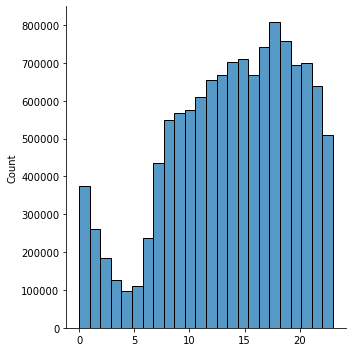

In [6]:
# plot histogram by hour only among other (excluding top 20) not vey common directions
ax = sns.displot([*map(int, yt[~yt['start-end'].isin(lst_top_yt)]['date_extract_hh_tpep_pickup_datetime'])], bins = 24)

In general the picture is the same as that of green taxi. One thing that stands out is a spike around 15 p.m. inside the distribution of 20 most common directions. I guess it is connected with tourism and shopping activity.

All in all, most popular directions of famous yellow taxi are inside Manhattan. The general patterns tell that people actively hire taxi in the morning and in the evening. In the evening the number of taxi rides is higher than in the morning beacuse people not only return to home but also head for entartainment. In general the middle of the day is also charectirized by intesne taxi activity with the most pronouncing case among top 20 most common directions. I guess it is connected with tourism and shopping.

# Part 3. Description

I suppose there is a way to detect the location of some institutions if one can be sure that attendance patterns of such instituions are unique. For example, night clubs tend to open after 10 p.m. and close around 6 a.m. Moreover, one can expect night club attendance maximum on Fridays and Saturdays. Also people do not tend to leave night clubs alone. Based on these assumptions, one can filter the dataset for thsese patterns and see whether threre are stable directions satisfying the criteria. 